# How to use DCAlign

We will show in the following the main steps needed to align a sequence to a seed model. 
As an example, we deal with the Pfam family PF00684 (two additional sections load and process the data for the Rfam family RF00059 and the synthetic sequences, where a co-evolution signal only is present, used in arXiv:2005.08500)




### 1. Let us load the DCAlign.jl package:


In [1]:
using Pkg
Pkg.activate("..")
using DCAlign
#include("../src/DCAlign.jl")
using DelimitedFiles
m = DCAlign


 Activating environment at `~/src/DCAlign/Project.toml`


DCAlign

### 2. Load couplings and fields (J,h)

Using **DCAlign.read_parameters** it is possible to load the parameters of the Potts model.

You can choose between Boltzmann-machine learned parameters or Pseudo-likelihood ones. 
The function assumes that: 

    BM-learned parameters use the format J i j a b and h i a where '-' -> 0
    plm-learned parameters use the format J a b i j and h a i where '-' -> 21

This must be specified in the variable _typel_ ("bm" , "plm") and in the variable _gap_ (0 or 21). 

Usage:
>J, h = DCAlign.read_parameters(file, q, L, gap=0, typel=Symbol("bm"))
    

In [2]:
## PF00677 data ##
open("../test/PF00684/")
q = 21; L = 67; 
ctype=Symbol("amino")
typel=Symbol("bm")

J, H = DCAlign.read_parameters("../test/PF00684/Parameters_bm_PF00684seed_potts.dat", q, L, gap=0, typel=typel);

┌ Info: Assuming J i j a b and h i a format
└ @ DCAlign /home/an-na/src/DCAlign/src/utils.jl:245
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ DCAlign /home/an-na/src/DCAlign/src/utils.jl:247
┌ Info: Gap in input file 0 now in 21
└ @ DCAlign /home/an-na/src/DCAlign/src/utils.jl:248


### 3. Load sequences

The sub-routine **DCAlign.enveloptoalign** takes as input 
1. a full set of non-aligned sequences alone 
2. a full set of non-aligned sequences together with a known alignment in two formats (a standard insertions-free MSA and a MSA where insertions are added as lower case symbols). 

All files should be written according to the FASTA layout

Ex.

PF1_full.fasta 

    >Seq01
    SLSTAQLLQPSGGLQASVISNIVLMKGQAKGLGFSIVGGDSIYSPIGIYVRTIFAGRAAAADGRLQEGDEILELNGESMAGLTHQDALQKFK
    QAKKGLLTLTVRTRLTAPHALGGPLSPPLSRS

PF1_align.fasta

    >Seq01/22-104
    -IVLMKGQAKGLGFSIVGGDSIYSPIGIYVRTIFAGRAAAADGLQEGDEILELNGESMAGLTHQDALQKFKQAKKLLTLTVR

PF1_ins.fasta

    >Seq01/22-104
    -IVLMKGQAKGLGFSIVGGDSIYSPIGIYVRTIFAGRAAAADGrLQEGDEILELNGESMAGLTHQDALQKFKQAKKgLLTLTVR
    
Only for RNA, the names of full-length sequences must contain the position of the hit (in agreement with the standard Rfam format).

You must also specify in _ctype_ the type of variables (amino-acids or nucleic bases) and, when the aligned sequences are added as input, the cut-off size _delta_ of the full length sequences (the final length will be _delta_ + _L_ + _delta_)

Usage
1. >seq = DCAlign.enveloptoalign("PF1_full.fasta", ctype=Symbol("amino"))
2. >seq = DCAlign.enveloptoalign("PF1_full.fasta", "PF1_align.fasta", "PF1_ins.fasta", delta = 20, ctype=Symbol("amino"))

In the fist case _seq_ is a dictionary whereas in the last case it contains for all sequences in _i_ = 1,...,M using the following format:
    
    seq[i][1] : name
    seq[i][2] : full length sequence
    seq[i][3] : aligned sequence
    seq[i][4] : aligned sequence with insertions


In [3]:
## PF00684 sequences ##

delta = 50;
al = m.enveloptoalign( "../test/PF00684/Test_PF00684.full", "../test/PF00684/Test_PF00684.fasta", "../test/PF00684/Test_PF00684.ins", delta = delta, ctype = ctype);
M = length(al)

println("Consider this sequence: ")
# consider one random sequence as an example
idx0 = rand(1:M) 
(aux,garb) = split(al[idx0][1], "/")
seqsol = al[idx0][3];
seqins = al[idx0][4];
seq = m.Seq(seqsol, al[idx0][2], ctype)
N = length(al[idx0][2])
println(al[idx0][1])
println("Full length: ")
println(al[idx0][2])
println("Aligned by HMMer (without and with insertions): ")
println(seqsol)
println(seqins)



Consider this sequence: 
A0A0W0VUG8_9GAMM/96-256
Full length: 
IFENIFSGGRGHARGSRAQRGADLQFNVQLTLEEAALGKQIEITVPRHVTCQSCNGSGARKGSSPKNCETCNGIGQVRIQQGFFSIQQTCPHCHGEGKVITDPCTACHGQGRVRESKKLTVKIPAGVDNGDRVRLSGEGEAGIHGGPPGDLYVQVNIKAHA
Aligned by HMMer (without and with insertions): 
CQSCNGSGARKGSPKNCETCNGIGQVRIQQ---GFF--SIQQTCPHCHGEGKVI--TDPCTACHGQG
CQSCNGSGARKGSsPKNCETCNGIGQVRIQQ---GFF--SIQQTCPHCHGEGKVI--TDPCTACHGQG


### 4. Load insertions and gap penalties

Load insertion penalties from a two columns text file. The gap penalties are two real numbers (they do not depend on positions).

In [4]:
## PF00684 ##
Lambda_all = readdlm("../test/PF00684/Lambda_PF00684.dat")
lambda_o = Lambda_all[:,1];
lambda_e = Lambda_all[:,2];


μext = 0.00;
μint = 2.50;

### 5. Run DCAlign

Run the approximate message-passing algorithm at a chosen temperature

In [5]:
# BP - large connectivity, (inv) temperature β, or β → + ∞ if T0 = true  (here put the parameter β = 1)

T0 = false
β = 1.0; μext = β * μext; μint = β * μint;
damp = 0.0
seed = 0
@time res=m.palign(seq, β.*J, β.*H, β.*lambda_o, β.* lambda_e, ctype = ctype ,mindec = 50, nprint=500, maxiter=2000, T0 = T0, μext=μext, μint =  μint,seed=seed, damp=damp, epsconv=1e-10 ,verbose=true); 

if !T0
    marg = deepcopy(res[3].pbf.P);
else
    marg = deepcopy(res[3].pbf.P);
    for i in 1:L
        h = exp.(marg[i])
        h .= h ./sum(h)
        marg[i] .= h
    end
    
end     
    
P = res[3].pbf.P 
out = m.decodeposterior(P, seq.strseq);
seqpa = out.pa # aligned seq 
seqpo = out.po # aligned seq with insertions
sat = m.check_assignment(P,true,N)
if sat == false
    (seqpa, P) = m.decimate_post(res[3],T0)
    out = m.decodeposterior(P, seq.strseq)
    seqpo = out.po
end
Ngap, Nins, Nb = m.count_gaps_ins(seqpo)
hdist, Gapp, Gapm, Sm = m.hammingdist(seqpa, seqsol)
println("sol ", seqsol)
println("mf  ", seqpa)
#println("mf ins", seqpo)
println("dist(mf, test) = ", hdist) 
en = m.compute_potts_en( J, H, seqpa, L,ctype)
ensol = m.compute_potts_en( J, H, seqsol, L,ctype)
seq_c = seqpa
println("(Potts) energy of mean-field approach ",en)
println("(Potts) energy of the compared sequence ", ensol)

println("mf ins:  ", seqpo)
println("sol ins: ", seqins)


println("mf cost function:  ", m.compute_cost_function(J,H,seqpo,L,ctype,lambda_o,lambda_e,μext,μint))
println("sol cost function: ", m.compute_cost_function(J,H,seqins,L,ctype,lambda_o,lambda_e,μext,μint))


Run Belief Propagation, large-connectivity approximation, for proteins alignment
L 67 = length of the Potts model
N 161 = length of the sequence A to be aligned
A: IFENIFSGGRGHARGSRAQRGADLQFNVQLTLEEAALGKQIEITVPRHVTCQSCNGSGARKGSSPKNCETCNGIGQVRIQQGFFSIQQTCPHCHGEGKVITDPCTACHGQGRVRESKKLTVKIPAGVDNGDRVRLSGEGEAGIHGGPPGDLYVQVNIKAHA
it = 26 -- en = -164.01 μext = 0.00 μint = 2.50 (ΔP,ΔB,ΔF) = 5.11e-13 9.97e-11 1.68e-12 
 15.583473 seconds (8.15 M allocations: 409.876 MiB, 0.92% gc time)
Let us check the assignment...
The subsequence satisfies the constraints
sol CQSCNGSGARKGSPKNCETCNGIGQVRIQQ---GFF--SIQQTCPHCHGEGKVI--TDPCTACHGQG
mf  CQSCNGSGARKGSPKNCETCNGIGQVRIQQ-GFSI-----QQTCPHCHGEGKVI--TDPCTACHGQG
dist(mf, test) = 7
(Potts) energy of mean-field approach -183.82413200000002
(Potts) energy of the compared sequence -165.12364100000002
mf ins:  CQSCNGSGARKGSsPKNCETCNGIGQVRIQQ-GfFSI-----QQTCPHCHGEGKVI--TDPCTACHGQG
sol ins: CQSCNGSGARKGSsPKNCETCNGIGQVRIQQ---GFF--SIQQTCPHCHGEGKVI--TDPCTACHGQG
mf cos

### 6. Extra: look at marginal probabilities

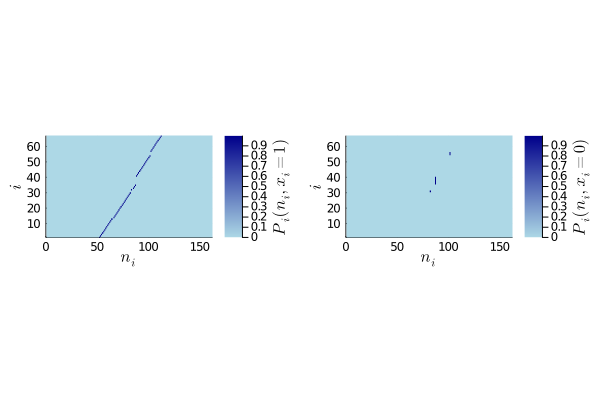

In [6]:
using Plots
using LaTeXStrings
N = length(seq.intseq)

M = zeros(L,N+2)

for i in 1:L
    h = marg[i]
    for n in 0:N+1
        M[i,n+1] = h[1,n]
    end
end

p1 = heatmap(M, c = :blues, aspect_ratio = 1.5, xlims = (0,N+1), ylims = (1,L), colorbar_title = L"P_{i}(n_{i}, x_{i} = 1)")
M = zeros(L,N+2)
for i in 1:L
    h = marg[i]
    for n in 0:N+1
        M[i,n+1] = h[0,n]
    end
end
p2 =  heatmap(M, c = :blues,colorbar_title = L"P_{i}(n_{i}, x_{i} = 0)", titlelocation = :left, aspect_ratio = 1.5, xlims = (0,N+1), ylims = (1,L))
plot(p1,p2, xlabel = L"n_{i}", ylabel = L"i")




## Other data 

These panels must be perfomed in alternative to steps 2), 3) and 4). 

In [7]:
## Synthetic data ##
q = 5; L = 50; 
ctype=Symbol("nbase")
typel=Symbol("bm")

J, H = m.read_parameters("../test/Synthetic_potts/Parameters_bm_train_potts.dat", q, L, gap=0, typel=typel);

delta = 200;
al = m.enveloptoalign( "../test/Synthetic_potts/Test_potts.full", "../test/Synthetic_potts/Test_potts.align", "../test/Synthetic_potts/Test_potts.ins", delta = delta, ctype = ctype);
M = length(al)
println(M)
# consider one random sequence as an example

idx0 = rand(1:M)
(aux,garb) = split(al[idx0][1], "/")
seqsol = al[idx0][3];
seqins = al[idx0][4];
seq = m.Seq(seqsol,al[idx0][2],ctype)
N = length(al[idx0][2])
println("Consider this synthetic sequence")
println(al[idx0][1])
println(al[idx0][2])
println("Solution (with and without insertions):")
println(seqsol)
println(seqins)

Lambda_all = readdlm("../test/Synthetic_potts/Lambda_train_potts.dat")
lambda_o = Lambda_all[:,1];
lambda_e = Lambda_all[:,2];


μext = 0.00;
μint = 0.00;

┌ Info: Assuming J i j a b and h i a format
└ @ DCAlign /home/an-na/src/DCAlign/src/utils.jl:245
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ DCAlign /home/an-na/src/DCAlign/src/utils.jl:247
┌ Info: Gap in input file 0 now in 5
└ @ DCAlign /home/an-na/src/DCAlign/src/utils.jl:248


25000
Consider this synthetic sequence
SEQ49560/3-56
CCAAAUAUUGAACACGUUUAUCGCAGCUUCAGAUGCGCUGAUCCUUGGUAGGGUCACGAACACA
Solution (with and without insertions):
AAAUAAACAGUUUAUCGCAGCUUCAGAUGCGCUGAUCCUUGGUAGGGUCA
AAAUAuugAACAcGUUUAUCGCAGCUUCAGAUGCGCUGAUCCUUGGUAGGGUCA


In [8]:
## RF00059 ##
q = 5; L = 105; 
ctype=Symbol("nbase")
typel=Symbol("bm")

J, H = m.read_parameters("../test/RF00059/Parameters_bm_RF00059seed_potts.dat", q, L, gap=0, typel=typel);

delta = 100;
al = m.enveloptoalign( "../test/RF00059/Test_RF00059.full", "../test/RF00059/Test_RF00059.fasta", "../test/RF00059/Test_RF00059.ins", delta = delta, ctype = ctype);
M = length(al)
println("Tot number of sequences ", M)
# consider one random sequence as an example
idx0 = rand(1:M) 
(aux,garb) = split(al[idx0][1], "/")
seqsol = al[idx0][3];
seqins = al[idx0][4];
seq = m.Seq(seqsol, al[idx0][2], ctype)
N = length(al[idx0][2])
println("Consider this sequence: ")
println(al[idx0][1])
println("Full length: ")
println(al[idx0][2])
println("Aligned by Infernal (without and with insertions): ")
println(seqsol)
println(seqins)

Lambda_all = readdlm("../test/RF00059/Lambda_RF00059.dat")
lambda_o = Lambda_all[:,1];
lambda_e = Lambda_all[:,2];


μext = 0.00;
μint = 1.50;

┌ Info: Assuming J i j a b and h i a format
└ @ DCAlign /home/an-na/src/DCAlign/src/utils.jl:245
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ DCAlign /home/an-na/src/DCAlign/src/utils.jl:247
┌ Info: Gap in input file 0 now in 5
└ @ DCAlign /home/an-na/src/DCAlign/src/utils.jl:248


Tot number of sequences 100
Consider this sequence: 
KV454478.1/90841-90749
Full length: 
TGTACGCATGACCGGTGCCATTTTATGGCTGAGATTATACGGTTGAACTTGATCTAGTTAATACTAGCGCAAAGAACATGCTATCATCGATAT
Aligned by Infernal (without and with insertions): 
UGUACGCAUGACCGGUGCCAUUUU--AUGGCUGAGAUU----------AUACGGUUGA-ACUUGAUCUAGUUAAUACUAGCGAAAGAACAUGCUAUCAUCGAUAU
UGUACGCAUGACCGGUGCCAUUUU--AUGGCUGAGAUU----------AUACGGUUGA-ACUUGAUCUAGUUAAUACUAGCGcAAAGAACAUGCUAUCAUCGAUAU
